# Exploring the *Ruegeria pomeroyi* FBA model

In [1]:
# Necessary imports
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import escher
from escher import Builder
import cobra

# Load model
model = cobra.io.read_sbml_model("../base_model/Rpom_06.xml")


Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


Thermodynamic consistency is apparently an issue with the base model. Begin exploring by counting bounds on reaction fluxes:

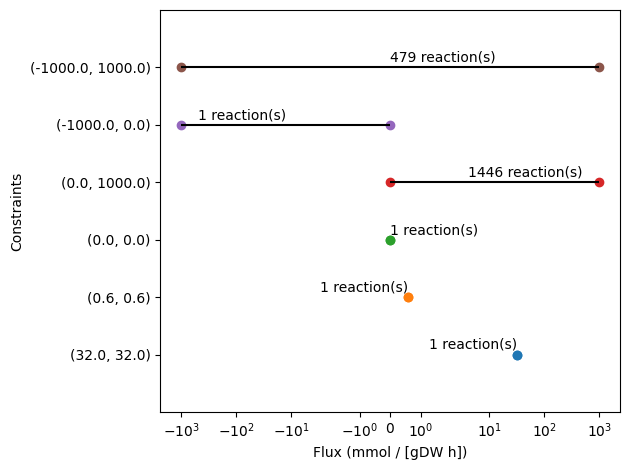

In [2]:
bounds = np.zeros((2, len(model.reactions)))

for c, reaction in enumerate(model.reactions):
    bounds[:, c] = reaction.lower_bound, reaction.upper_bound

bounds_counter = Counter([tuple(bounds[:, c]) for c in range(bounds.shape[1])])
bounds_counter = list(bounds_counter.items())

bounds_counter.sort(key=lambda x: abs(x[0][1] - x[0][0]))

fig, ax = plt.subplots()
for y, ((lb, ub), count) in enumerate(bounds_counter):
    ax.hlines(y, lb, ub, color="k")
    ax.scatter([lb, ub], [y, y])
    middle = (lb + ub) / 2
    ax.text(middle, y + 0.1,
            f"{count} reaction(s)",
            horizontalalignment="right" if middle > 0 else "left")
ax.set_xscale("symlog")
ax.set_ybound(-1, y + 1)
ax.set_yticks(list(range(y + 1)))
ax.set_yticklabels([bounds for bounds, _ in bounds_counter])
ax.set_xlabel("Flux (mmol / [gDW h])")
ax.set_ylabel("Constraints")
fig.tight_layout()


Get reactions that involve NADH:

In [3]:
nadh = model.metabolites.get_by_id("NADH[c]")
nadh_reactions = model.reactions.query(
    lambda m: nadh in m, attribute="metabolites")
len(nadh_reactions)

193

Can we build a Escher diagram containing all reactions affecting NADH?

In [4]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.escher_utils.mapbuilder import MapBuilder

In [5]:
mapbuilder = MapBuilder(template="../utils/escher_utils/template.json",
                        name="nadh_reaction_map")

for rxn in nadh_reactions:
    mapbuilder.add_reaction(rxn)

mapbuilder.write("./nadh_reactions_map.json")

Need to load the map manually using Map>Load map JSON:

In [6]:
builder = Builder()
builder.model = model
builder

Builder()